<a href="https://colab.research.google.com/github/p25-c4/car/blob/main/0309_car_project_%EC%83%81%EA%B4%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import stats


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data

In [3]:
# df = pd.read_csv("data/data2/Car.csv")
# df.head()

In [4]:
# df['Engine'] = pd.to_numeric(df['Engine'].replace(' CC', "", regex=True),errors = 'coerce')
# df['Mileage'] = pd.to_numeric(df['Mileage'].replace(' kmpl', "", regex=True),errors = 'coerce')
# df['Power'] = pd.to_numeric(df['Power'].replace(' bhp', "", regex=True),errors = 'coerce')
# df['Brand'] = df['Name'].str.split().str[0]
# df.head()

In [5]:
# df.to_csv("car_used.csv", index=False)

In [6]:
df = pd.read_csv("/content/drive/MyDrive/포스코/car_used.csv")
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi


In [7]:
df.select_dtypes(include=['int64'])

,Year,Kilometers_Driven
0,2010,72000
1,2015,41000
2,2011,46000
3,2012,87000
4,2013,40670
...,...,...
7248,2011,89411
7249,2015,59000
7250,2012,28000
7251,2013,52262


# EDA & Preprocessing

- 데이터 전처리 항목
    1. Owner_Type: 숫자형으로 변환, 4 이상은 4로 처리(O)
        - 4 이상인 자료가 12개 밖에 되지 않아 4로 처리함
   
    2. Brand: 국가(대륙) 별로 feature 추가 (O)
        - Brand별 가격 차이가 있을 것으로 생각해 Brand feature 추가
        - 비슷한 국가, 대륙의 Brand 가격이 비슷할 것으로 생각하여 국가(대륙)별로 묶으려 하였으나, 데이터를 살펴본 결과 그렇지 않아서 그룹화 기준 변경
        - Brand에 따른 가격의 median을 내림차순 정렬하여 적절한 선에서 4가지 그룹으로 파생변수 Brand_level 생성
   
    3. Location: 지역별 가격 차이가 있어 보여서, dummy변수 처리후 모델평가 과정에서 제외 여부 결정.
   
    4. Year --> 연식(age) (O)
        - Year 별 Price 산점도를 확인한 결과, 오래된 차 일수록 가격이 낮은 경향이 있음.
        - Price가 비슷한 시기에 측정된 것으로 추측됨.
        - 따라서 회귀분석에 적절한 'age' feature를 추가함.
    
    5. 결측치 -->
        5-1. New_Price column 제거
        결측치가 너무 많아서(약 90%가 결측치)
    
    6. 이상치 --> Price로 찾아서 개별적 제거여부 결정

    7. Kilometer

    8. Mileage
        - 0으로 되어있는 결측치
        - Mileage와 Engine 상관계수(0인 값이 있음에도) 0.59로 높음
        - 휘발유와 경유로 나누어서 Mileage ~ Engine 선형회귀 적용

    9. Engine
        - 46개 결측치 --> 직접 차량 찾아서 채워 넣음
        - 동시에 Power도 결측치인 값 직접 찾아서 채워 넣음

    10. Power
        - Engine과 상관관계 0.86
        - Power ~ Engine 선형회귀를 통해 결측치 대체

    11. Seats
        - 결측치 직접 찾아서 대체

    12. Owner_Type_Id
    
    13. Age

## Owner_Type

In [8]:
df[df['Owner_Type']=='Fourth & Above']

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand
29,Toyota Innova 2.5 V Diesel 7-seater,Mumbai,6131.84,2007,262000,Diesel,Manual,Fourth & Above,12.8,2494.0,102.00,7.0,NaN,Toyota
885,Maruti Grand Vitara AT,Chennai,8431.28,2008,77000,Petrol,Automatic,Fourth & Above,9.7,1995.0,163.50,5.0,NaN,Maruti
1081,Hyundai i20 1.2 Sportz Option,Bangalore,4982.12,2010,61000,Petrol,Manual,Fourth & Above,17.0,1197.0,80.00,5.0,NaN,Hyundai
1699,Ford Endeavour 4x2 XLT Limited Edition,Pune,4598.88,2007,90000,Diesel,Manual,Fourth & Above,10.9,2499.0,143.00,7.0,NaN,Ford
2988,Toyota Innova 2.5 G4 Diesel 8-seater,Chennai,7818.10,2005,240000,Diesel,Manual,Fourth & Above,12.8,2494.0,102.00,8.0,NaN,Toyota
3368,Maruti Swift Ldi BSIII,Pune,3295.86,2009,80000,Diesel,Manual,Fourth & Above,17.8,1248.0,75.00,5.0,NaN,Maruti
3404,Maruti Swift 1.3 VXi,Jaipur,3602.46,2006,125000,Petrol,Manual,Fourth & Above,16.1,NaN,NaN,NaN,NaN,Maruti
4148,Ford Ikon 1.3 Flair,Coimbatore,3019.93,2008,59833,Petrol,Manual,Fourth & Above,13.8,1299.0,70.00,5.0,NaN,Ford
5647,Toyota Qualis Fleet A3,Mumbai,3372.51,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446.0,NaN,8.0,NaN,Toyota
6226,Maruti Omni E 8 Str STD,Bangalore,NaN,2005,81245,Petrol,Manual,Fourth & Above,16.8,796.0,34.20,8.0,NaN,Maruti


In [9]:
# Owner_Type 숫자형으로
df.loc[df["Owner_Type"]=="First", "Owner_Type_id"] = 1
df.loc[df["Owner_Type"]=="Second", "Owner_Type_id"] = 2
df.loc[df["Owner_Type"]=="Third", "Owner_Type_id"] = 3
df.loc[df["Owner_Type"]=="Fourth & Above", "Owner_Type_id"] = 4
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0


## Brand

In [10]:
df.groupby(["Brand"])["Price"].describe().sort_values(by="50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
Lamborghini,1.0,183955.200000,NaN,183955.20,183955.2000,183955.200,183955.2000,183955.20
Porsche,18.0,74116.061111,30096.092377,3096.58,62433.6275,72079.780,96940.5575,114972.00
Land,60.0,60183.243000,37014.510316,16862.56,33000.7975,53653.600,72608.6475,245273.60
Jaguar,43.0,59961.551628,28201.301675,24527.36,40830.3900,50281.090,73321.4750,153296.00
Bentley,2.0,48096.620000,59889.144224,5748.60,26922.6100,48096.620,69270.6300,90444.64
Mini,29.0,43103.134828,10758.015072,26060.32,33725.1200,38324.000,53653.6000,68354.69
Mercedes-Benz,325.0,42135.740369,25972.143599,1624.94,22227.9200,37557.520,55186.5600,141047.65
Audi,241.0,40017.252863,19747.788417,11497.20,26826.8000,36407.800,49851.8600,111814.10
BMW,273.0,39660.763590,24476.634075,2422.08,21384.7900,32698.040,50587.6800,143592.36


In [11]:
import plotly.express as px
fig = px.scatter(df,x='Brand',y='Price')
fig.show()

In [12]:
# Brand_Country feature 추가
india_car = ["Ambassador", "Force", "Hindustan", "Mahindra", "Maruti", "Tata"]
eu_car = ["Audi", "BMW", "Bentley", "Fiat", "Jaguar", "Lamborghini", "Land", "Mercedes-Benz",
          "Mini", "OpelCorsa", "Porsche", "Renault", "Skoda", 'Smart', 'Volkswagen','Volvo' ]
us_car = ['Chevrolet', 'Ford', 'Jeep']
jp_car = ["Datsun", "Honda","ISUZU", "Mitsubishi","Nissan","Toyota"]
kr_car = ['Hyundai']

df.loc[df["Brand"].isin(india_car),"Brand_Country"] = "India"
df.loc[df["Brand"].isin(eu_car),"Brand_Country"] = "Europe"
df.loc[df["Brand"].isin(us_car),"Brand_Country"] = "US"
df.loc[df["Brand"].isin(jp_car),"Brand_Country"] = "Japan"
df.loc[df["Brand"].isin(kr_car),"Brand_Country"] = "Korea"

In [13]:
# Brand_level feature 추가
brand_h = ['Lamborghini', 'Porsche', 'Land', 'Jaguar', 'Bentley', 'Mini',
       'Mercedes-Benz', 'Audi', 'BMW']
brand_mh = ['Jeep', 'Volvo', 'ISUZU', 'Mitsubishi',
       'Toyota', 'Force', 'Mahindra', 'Skoda']
brand_ml = ['Ford', 'Renault', 'Honda',
       'Volkswagen', 'Hyundai', 'Nissan', 'Maruti']
brand_l = ['Datsun', 'Smart', 'Tata',
       'Fiat', 'Chevrolet', 'Ambassador', 'Hindustan', 'OpelCorsa']

df.loc[df["Brand"].isin(brand_h),"Brand_level"] = "high"
df.loc[df["Brand"].isin(brand_mh),"Brand_level"] = "middle_high"
df.loc[df["Brand"].isin(brand_ml),"Brand_level"] = "middle_low"
df.loc[df["Brand"].isin(brand_l),"Brand_level"] = "low"

In [14]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id,Brand_Country,Brand_level
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0,India,middle_low
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0,Korea,middle_low
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0,Japan,middle_low
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0,India,middle_low
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0,Europe,high


## Location

<ipython-input-15-28b578d329f4>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Location', ylabel='Price'>

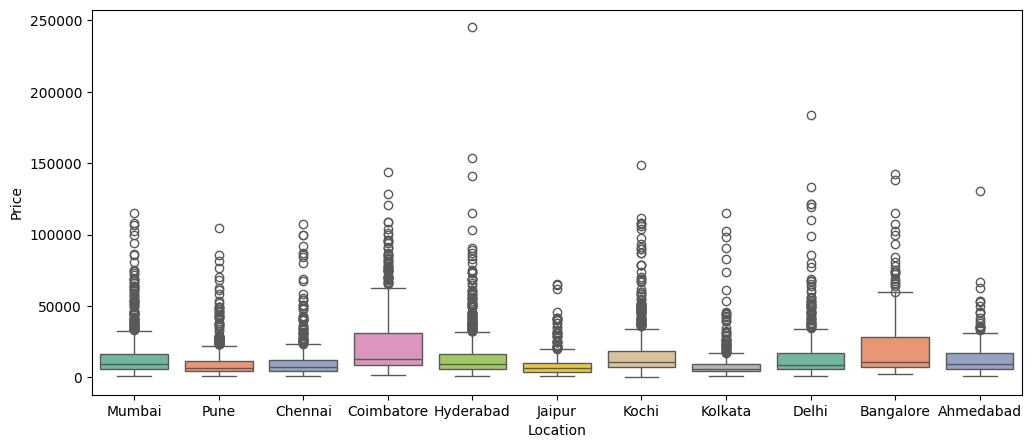

In [15]:
# Location별 Price
fig, axes = plt.subplots(figsize=(12,5))
sns.boxplot(data = df, y="Price", x="Location", palette="Set2")

In [16]:
pivot_car = df.pivot_table(index = "Location", columns="Brand_level", values="Price", aggfunc='count')
pivot_car

Brand_level,high,low,middle_high,middle_low
Location,,,,
Ahmedabad,35,11,39,148
Bangalore,100,18,55,192
Chennai,62,39,83,322
Coimbatore,161,38,104,361
Delhi,103,11,127,331
Hyderabad,117,42,127,473
Jaipur,23,39,52,310
Kochi,115,32,90,439
Kolkata,52,46,62,392


In [17]:
pivot_table = df.pivot_table(index='Location', columns='Brand_level', values="Price", aggfunc='count')

pivot_table['high_ratio'] = (pivot_table['high'] / pivot_table.sum(axis=1)).round(3)
pivot_table['low_ratio'] = (pivot_table['low'] / pivot_table.sum(axis=1)).round(3)
pivot_table['middlehigh_ratio'] = (pivot_table['middle_high'] / pivot_table.sum(axis=1)).round(3)
pivot_table['middlelow_ratio'] = (pivot_table['middle_low'] / pivot_table.sum(axis=1)).round(3)

pivot_table

Brand_level,high,low,middle_high,middle_low,high_ratio,low_ratio,middlehigh_ratio,middlelow_ratio
Location,,,,,,,,
Ahmedabad,35,11,39,148,0.150,0.047,0.167,0.634
Bangalore,100,18,55,192,0.274,0.049,0.151,0.525
Chennai,62,39,83,322,0.123,0.077,0.164,0.636
Coimbatore,161,38,104,361,0.242,0.057,0.157,0.543
Delhi,103,11,127,331,0.180,0.019,0.222,0.578
Hyderabad,117,42,127,473,0.154,0.055,0.167,0.623
Jaipur,23,39,52,310,0.054,0.092,0.123,0.731
Kochi,115,32,90,439,0.170,0.047,0.133,0.649
Kolkata,52,46,62,392,0.094,0.083,0.112,0.710


## Year
    - Age(연식) 변수 추가(2020년 기준)

<Axes: xlabel='Year', ylabel='Price'>

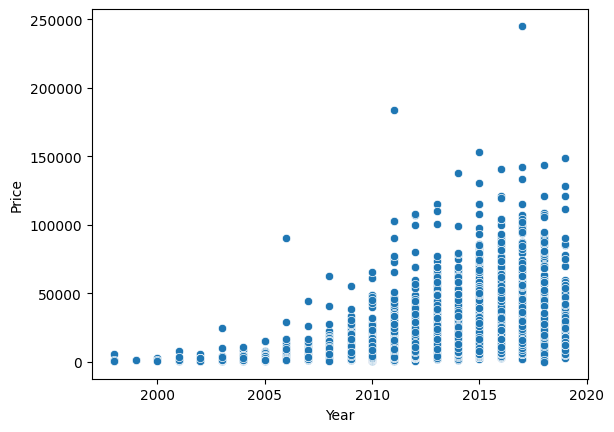

In [18]:
# year, Price scatter plot
sns.scatterplot(data=df, x="Year", y="Price")

In [19]:
# Age 추가
df['Age'] = 2020 - df['Year']
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,Audi,2.0,Europe,high,7


## New_Price

In [20]:
# New_Price 제거
df = df.drop(columns = "New_Price")

In [21]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1.0,India,middle_low,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,2.0,Europe,high,7


## Kilometers_Driven

<Axes: xlabel='Kilometers_Driven', ylabel='Count'>

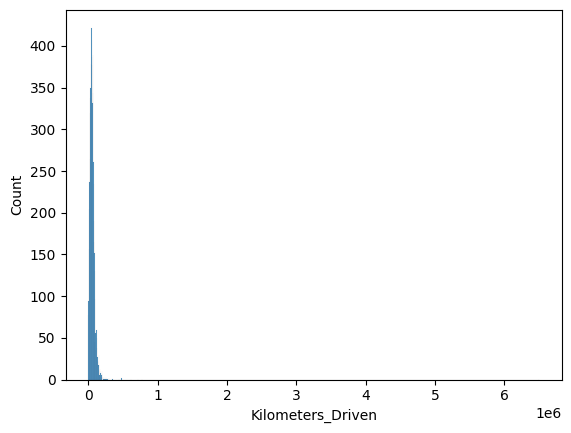

In [22]:
sns.histplot(data=df, x= df["Kilometers_Driven"])

- right skewed --> box-cox 변환 column 추가

<Axes: xlabel='Kilometers_scaled', ylabel='Count'>

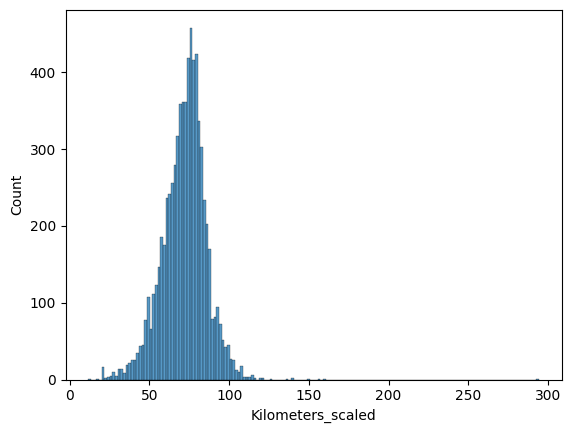

In [23]:
df["Kilometers_scaled"] = stats.boxcox(df["Kilometers_Driven"])[0]
sns.histplot(data=df, x= "Kilometers_scaled")

## Engine
    - 46개 결측치 직접 차량 정보 찾아서 입력

<Axes: xlabel='Engine', ylabel='Price'>

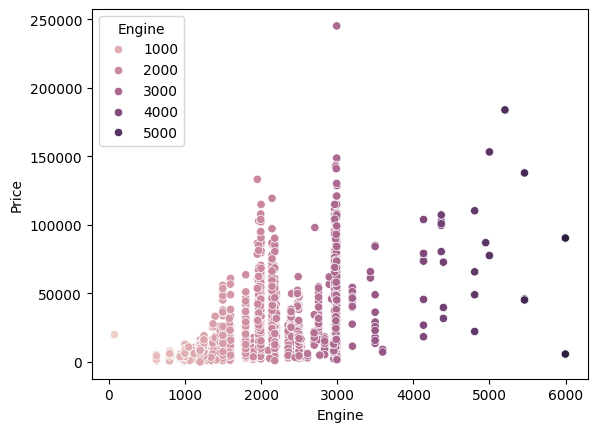

In [24]:
# 종속변수와의 관계
sns.scatterplot(data=df, x="Engine", y="Price", hue="Engine")

In [25]:
# 결측치 인덱스
df[df['Engine'].isnull()].index

Int64Index([ 194,  208,  733,  749, 1294, 1327, 1385, 1460, 2074, 2096, 2264,
            2325, 2335, 2530, 2542, 2623, 2668, 2737, 2780, 2842, 3272, 3404,
            3520, 3522, 3810, 4011, 4152, 4229, 4577, 4604, 4697, 4712, 4952,
            5015, 5185, 5270, 6042, 6541, 6544, 6633, 6643, 6651, 6677, 6685,
            6880, 6902],
           dtype='int64')

In [26]:
# 직접 찾은 Engine, Power data
idx_ls = df[df['Engine'].isnull()].index
engine_ls = [1497, 1197, 1197, 2993, 1497, 1197, 1493, 2993, 1248, 999,
             1197, 1197, 1298, 1995, 999, 1995, 1197, 1061, 999, 999, 1995,
             1298, 1995, 999, 2354, 1248, 3000, 1086, 1995, 1198, 1172, 1086, 1368,
             1298, 1197, 1493, 1798, 1364, 1396, 2179, 1995, 1197, 1368, 1298,
             1995, 1197]
power_ls = [77, 83, 83, 242,98, 83, 100, 241, 75, 62, 80, 83, 87, 181, 62, 181, 85, 67, 210,
            62, 174, 87, 184, 62, 200, 76, 175, 210, 188, 90, 67, 62, 89, 89, 85, 100,
            158, 68, 99, 120, 175, 83, 90, 87, 177, 80]

In [27]:
# 결측치 채우기
for idx in range(len(idx_ls)):
    df.loc[idx_ls[idx],["Engine", "Power"]] = np.array([engine_ls[idx], power_ls[idx]])

In [28]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                 129
Seats                  53
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
Kilometers_scaled       0
dtype: int64

## Seats

In [29]:
# Land Rover 7인승
# Mahindra TUV 300 P4 7인승
# 나머지 5인승

df.loc[df['Name'].str.contains('Land Rover'), 'Seats'] = 7
df.loc[df['Name'].str.contains('Mahindra'), 'Seats'] = 7
df['Seats'].fillna(5, inplace=True)

In [30]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                 129
Seats                   0
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
Kilometers_scaled       0
dtype: int64

## Power
    - Power ~ Engine 선형회귀 적합하여 결측치 대체

<Axes: xlabel='Power', ylabel='Count'>

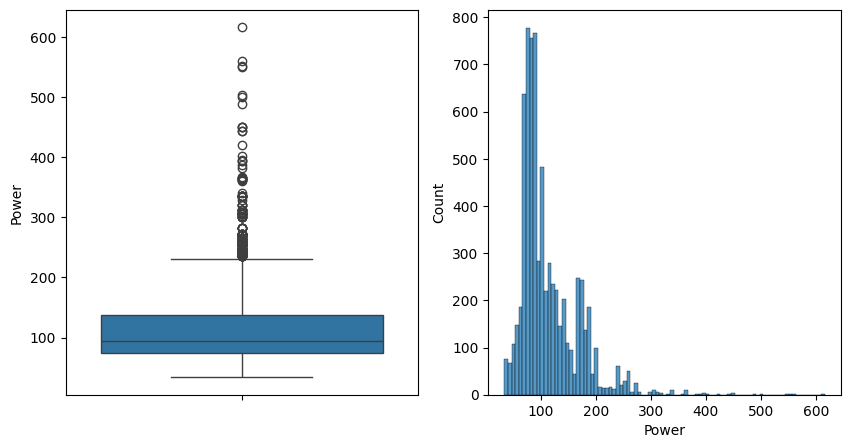

In [31]:
# plotting
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

plt.subplot(121)
sns.boxplot(data=df, y= 'Power')

plt.subplot(122)
sns.histplot(data=df, x = 'Power')

Power 분석

Power는 평균 112.7652로 100~200 사이에 거의 모든 값이 분포되어있음.
200이상의 power 값은 이상치라고 판단할 수 있으며 418개의 데이터가 200이상의 데이터를 가짐. --> 수정 필요

<Axes: xlabel='Power', ylabel='Engine'>

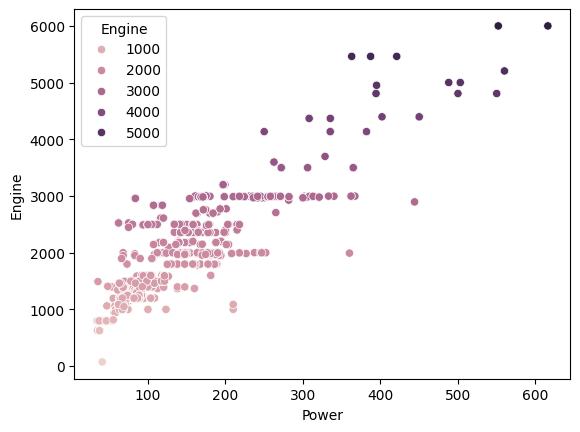

In [32]:
# Power와 Engine 관계
sns.scatterplot(data = df, x = "Power", y="Engine", hue="Engine")

<ipython-input-33-f0d2a78bfd61>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

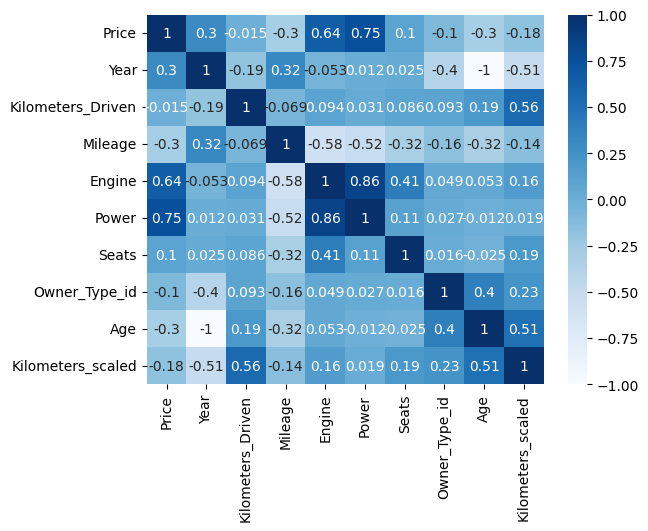

In [33]:
df_corr = df.corr()
sns.heatmap(data = df_corr, annot=True, cmap="Blues")

- Power와 Engine의 상관계수 = 0.86
- 매우 강한 선형관계가 있다고 판단.
- Power ~ Engine의 1차 선형회귀를 통해 결측치 대체.

In [34]:
# Power가 null인 dataframe
power_null_idx = df[df["Power"].isnull()].index
df_Engine_power_null = df.loc[~df.index.isin(power_null_idx), ['Engine']]
df_Power_power_null = df.loc[~df.index.isin(power_null_idx), ['Power']]
df_Engine_linear = df.loc[power_null_idx, ['Engine']]

In [35]:
# 회귀 적합
linear_model = LinearRegression()
linear_model.fit(df_Engine_power_null,df_Power_power_null)
Power_linear = linear_model.predict(df_Engine_linear)
df.loc[power_null_idx, "Power"] = Power_linear

In [36]:
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Power                   0
Seats                   0
Brand                   0
Owner_Type_id           0
Brand_Country           0
Brand_level             0
Age                     0
Kilometers_scaled       0
dtype: int64

## Owner_Type_id

<Axes: xlabel='Owner_Type_id', ylabel='Price'>

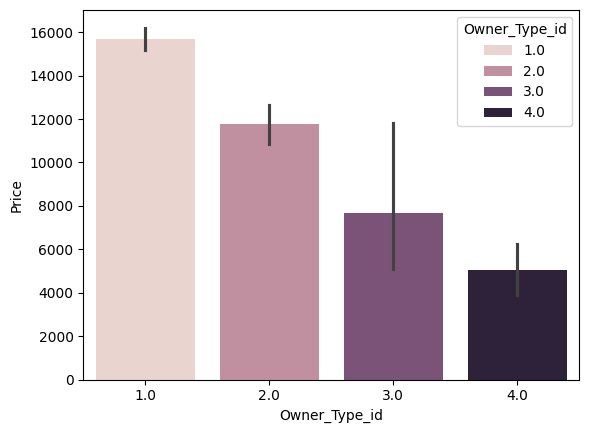

In [37]:
# first Owner가 압도적으로 많아 fourth 이상은 측정되지 않음.
sns.barplot(data = df, x= 'Owner_Type_id', y="Price", hue="Owner_Type_id")

## Mileage
    - 결측값과 0으로

In [38]:
# null값인 Mileage
df[df['Mileage'].isnull()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age,Kilometers_scaled
4446,Mahindra E Verito D4,Chennai,19928.48,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,7.0,Mahindra,1.0,India,middle_high,4,71.749891
4904,Toyota Prius 2009-2016 Z4,Mumbai,19545.24,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,Toyota,1.0,Japan,middle_high,9,69.078661


- 전기차라 연비가 없음 --> 0으로 처리

In [39]:
# 0으로 들어간 Mileage
df[df["Mileage"]==0]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age,Kilometers_scaled
14,Land Rover Freelander 2 TD4 SE,Pune,26826.80,2012,85000,Diesel,Automatic,Second,0.0,2179.0,115.000000,7.0,Land,2.0,Europe,high,8,83.929865
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,54680.68,2019,15369,Diesel,Automatic,First,0.0,1950.0,194.000000,5.0,Mercedes-Benz,1.0,Europe,high,1,50.406255
79,Hyundai Santro Xing XL,Hyderabad,1992.85,2005,87591,Petrol,Manual,First,0.0,1086.0,71.578297,5.0,Hyundai,1.0,Korea,middle_low,15,84.675225
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.0,1497.0,77.000000,5.0,Honda,1.0,Japan,middle_low,13,75.732852
229,Ford Figo Diesel,Bangalore,5518.66,2015,70436,Diesel,Manual,First,0.0,1498.0,99.000000,5.0,Ford,1.0,US,middle_low,5,79.405440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6633,Mahindra TUV 300 P4,Kolkata,NaN,2016,27000,Diesel,Manual,First,0.0,2179.0,120.000000,7.0,Mahindra,1.0,India,middle_high,4,59.717925
6697,Hyundai Santro Xing XL,Jaipur,NaN,2007,85000,Petrol,Manual,Second,0.0,1086.0,71.578297,5.0,Hyundai,2.0,Korea,middle_low,13,83.929865
6857,Land Rover Freelander 2 TD4 SE,Mumbai,NaN,2011,87000,Diesel,Automatic,First,0.0,2179.0,115.000000,7.0,Land,1.0,Europe,high,9,84.506617
6957,Honda Jazz 2020 Petrol,Kochi,NaN,2019,11574,Petrol,Manual,First,0.0,1199.0,88.700000,5.0,Honda,1.0,Japan,middle_low,1,46.251779


In [40]:
# Mileage 결측값 0으로 채우기
df.loc[4446, "Mileage"] = 0
df.loc[4904, "Mileage"] = 0

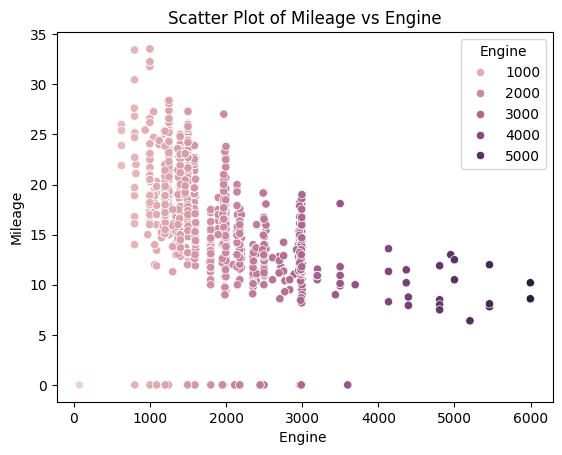

In [41]:
# Mileage, Engine 관계(상관계수 0.59)
sns.scatterplot(x='Engine', y='Mileage', data=df, hue='Engine')

plt.title('Scatter Plot of Mileage vs Engine')
plt.xlabel('Engine ')
plt.ylabel('Mileage')

plt.legend(title='Engine')

plt.show()

<Axes: xlabel='Fuel_Type', ylabel='Mileage'>

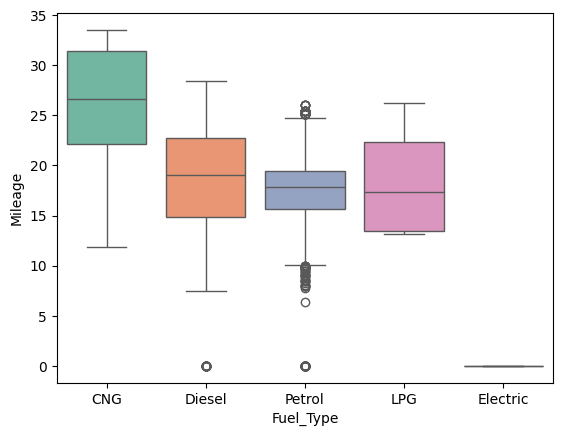

In [42]:
# 연료별 Mileage
sns.boxplot(x='Fuel_Type', y='Mileage', data=df, hue = "Fuel_Type", palette="Set2")

- Mileage와 Engine의 상관관계는 0.59
- 결측값(0)이 있는 부분만 생각하면 더 강한 선형성을 띈다.
- 경유차와 휘발유차의 연비가 차이가 있음을 고려
- 경유차와 휘발유차를 구분하여 Mileage ~ Engine 선형회귀를 통해 결측치 대체

In [43]:
## Diesel
# Mileage가 0인 dataframe
Diesel_Mileage_null_idx = df.loc[(df["Mileage"]==0) & (df["Fuel_Type"]=="Diesel") ].index      ## Diesel & Mileage =0인 idx
df_Engine_Diesel_Mileage_notnull = df.loc[~df.index.isin(Diesel_Mileage_null_idx), ['Engine']]    ## Diesel & Mileage =0인걸 제외한 Engine
df_Mileage_Diesel_Mileage_notnull = df.loc[~df.index.isin(Diesel_Mileage_null_idx), ['Mileage']]  ## Diesel & Mileage =0인걸 제외한 Mileage
df_Engine_linear_Mileage_null = df.loc[Diesel_Mileage_null_idx, ['Engine']]  ## Diesel & Mileage =0인 Engine

In [44]:
# Mileage_Diesel 회귀 적합
linear_model_Diesel = LinearRegression()
linear_model_Diesel.fit(df_Engine_Diesel_Mileage_notnull,df_Mileage_Diesel_Mileage_notnull)
Mileage_Diesel_linear = linear_model.predict(df_Engine_linear_Mileage_null)
df.loc[Diesel_Mileage_null_idx, "Mileage"] = Mileage_Diesel_linear

In [45]:
## Petrol
# Mileage가 0인 dataframe
Petrol_Mileage_null_idx = df.loc[(df["Mileage"]==0) & (df["Fuel_Type"]=="Petrol") ].index      ## Petrol & Mileage =0인 idx
df_Engine_Petrol_Mileage_notnull = df.loc[~df.index.isin(Petrol_Mileage_null_idx), ['Engine']]    ## Petrol & Mileage =0인걸 제외한 Engine
df_Mileage_Petrol_Mileage_notnull = df.loc[~df.index.isin(Petrol_Mileage_null_idx), ['Mileage']]  ## Petrol & Mileage =0인걸 제외한 Mileage
df_Engine_linear_Mileage_null = df.loc[Petrol_Mileage_null_idx, ['Engine']]  ## Petrol & Mileage =0인 Engine

In [46]:
# Mileage_Petrol 회귀 적합
linear_model_Petrol = LinearRegression()
linear_model_Petrol.fit(df_Engine_Petrol_Mileage_notnull,df_Mileage_Petrol_Mileage_notnull)
Mileage_Petrol_linear = linear_model.predict(df_Engine_linear_Mileage_null)
df.loc[Petrol_Mileage_null_idx, "Mileage"] = Mileage_Petrol_linear

# Data split

In [47]:
# 제출용(예측용) 데이터
submission = df[pd.isnull(df['Price'])]
data = df.drop(submission.index)
data.shape, submission.shape

((6200, 18), (1053, 18))

In [48]:
# 목표변수 및 설명변수
y = data['Price']
X = data.drop('Price',axis=1)

In [49]:
X.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Brand', 'Owner_Type_id', 'Brand_Country', 'Brand_level', 'Age',
       'Kilometers_scaled'],
      dtype='object')

In [50]:
X_dummies = pd.get_dummies(X[['Location', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Mileage', 'Engine', 'Power', 'Seats',
       'Brand', 'Owner_Type_id',  'Brand_level', 'Age']])
X_dummies

,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,Brand_level_high,Brand_level_low,Brand_level_middle_high,Brand_level_middle_low
0,72000,26.60,998.0,58.16,5.0,1.0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,41000,19.67,1582.0,126.20,5.0,1.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,46000,18.20,1199.0,88.70,5.0,1.0,9,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,87000,20.77,1248.0,88.76,7.0,1.0,8,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,40670,15.20,1968.0,140.80,5.0,2.0,7,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,41413,27.28,1047.0,69.00,5.0,1.0,4,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7231,39015,17.00,1497.0,121.36,5.0,1.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7232,6000,16.00,1368.0,160.00,5.0,1.0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7235,21380,24.30,1248.0,88.50,5.0,1.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
# train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4960, 59), (1240, 59), (4960,), (1240,))

In [52]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8544211628842562

In [53]:
# 수치형 칼럼만 뽑아냄
num_columns = df.select_dtypes(include=['int','float']).columns

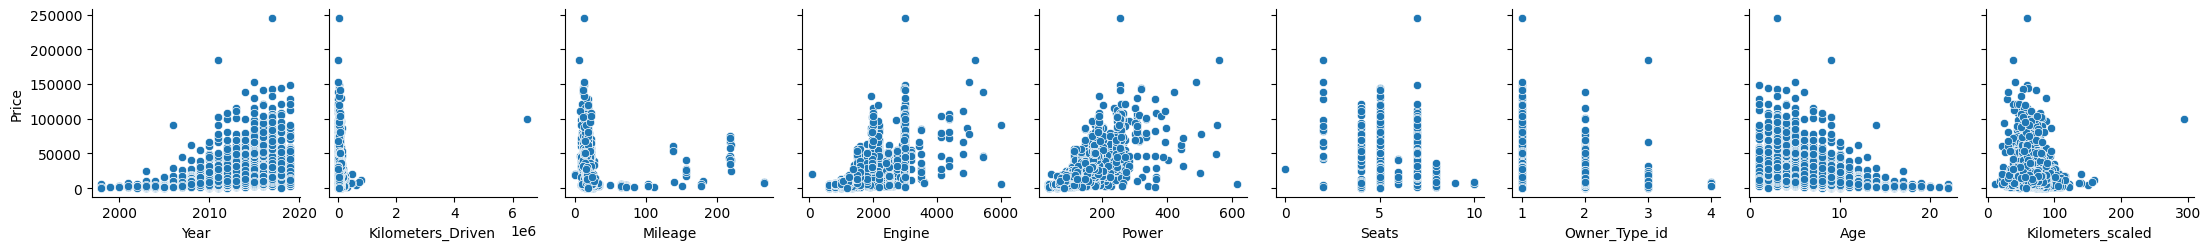

In [55]:
# 목적변수와 수치형설명변수간 산점도
selected_df = df[num_columns]

sns.pairplot(selected_df, y_vars='Price', x_vars=num_columns[1:])

In [63]:
# 목적-설명 상관계수
num_corr = df[num_columns].corr(method='pearson')
num_corr

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_id,Age,Kilometers_scaled
Price,1.000000,0.303140,-0.014603,-0.041738,0.641022,0.754051,0.100273,-0.100691,-0.303140,-0.178288
Year,0.303140,1.000000,-0.187859,0.013726,-0.053232,0.022239,0.024617,-0.395335,-1.000000,-0.505355
Kilometers_Driven,-0.014603,-0.187859,1.000000,-0.013144,0.094424,0.029203,0.085586,0.092618,0.187859,0.562297
Mileage,-0.041738,0.013726,-0.013144,1.000000,-0.113494,-0.120677,-0.073046,-0.012670,-0.013726,-0.028438
Engine,0.641022,-0.053232,0.094424,-0.113494,1.000000,0.860827,0.407037,0.049089,0.053232,0.162685
Power,0.754051,0.022239,0.029203,-0.120677,0.860827,1.000000,0.111147,0.021031,-0.022239,0.013955
Seats,0.100273,0.024617,0.085586,-0.073046,0.407037,0.111147,1.000000,0.015878,-0.024617,0.190675
Owner_Type_id,-0.100691,-0.395335,0.092618,-0.012670,0.049089,0.021031,0.015878,1.000000,0.395335,0.229704
Age,-0.303140,-1.000000,0.187859,-0.013726,0.053232,-0.022239,-0.024617,0.395335,1.000000,0.505355
Kilometers_scaled,-0.178288,-0.505355,0.562297,-0.028438,0.162685,0.013955,0.190675,0.229704,0.505355,1.000000


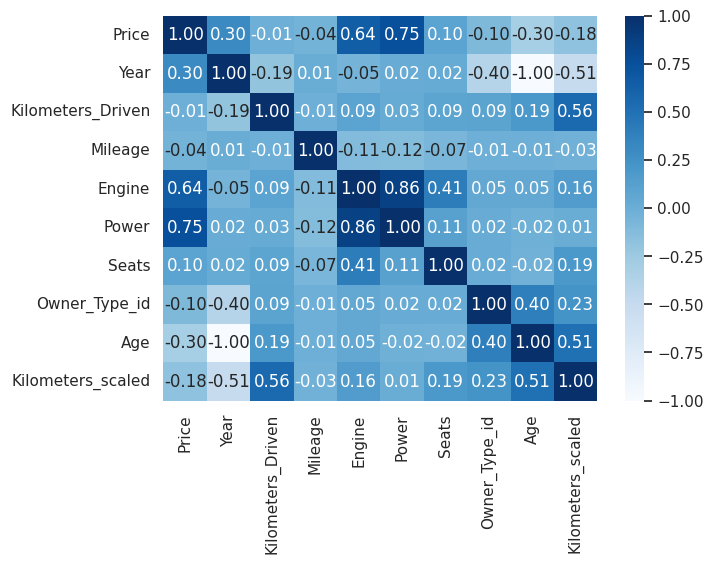

In [76]:
# 상관관계 히트맵
plt.figure(figsize=(7,5))

hm = sns.heatmap(num_corr,annot=True,fmt='.2f',cmap='Blues')

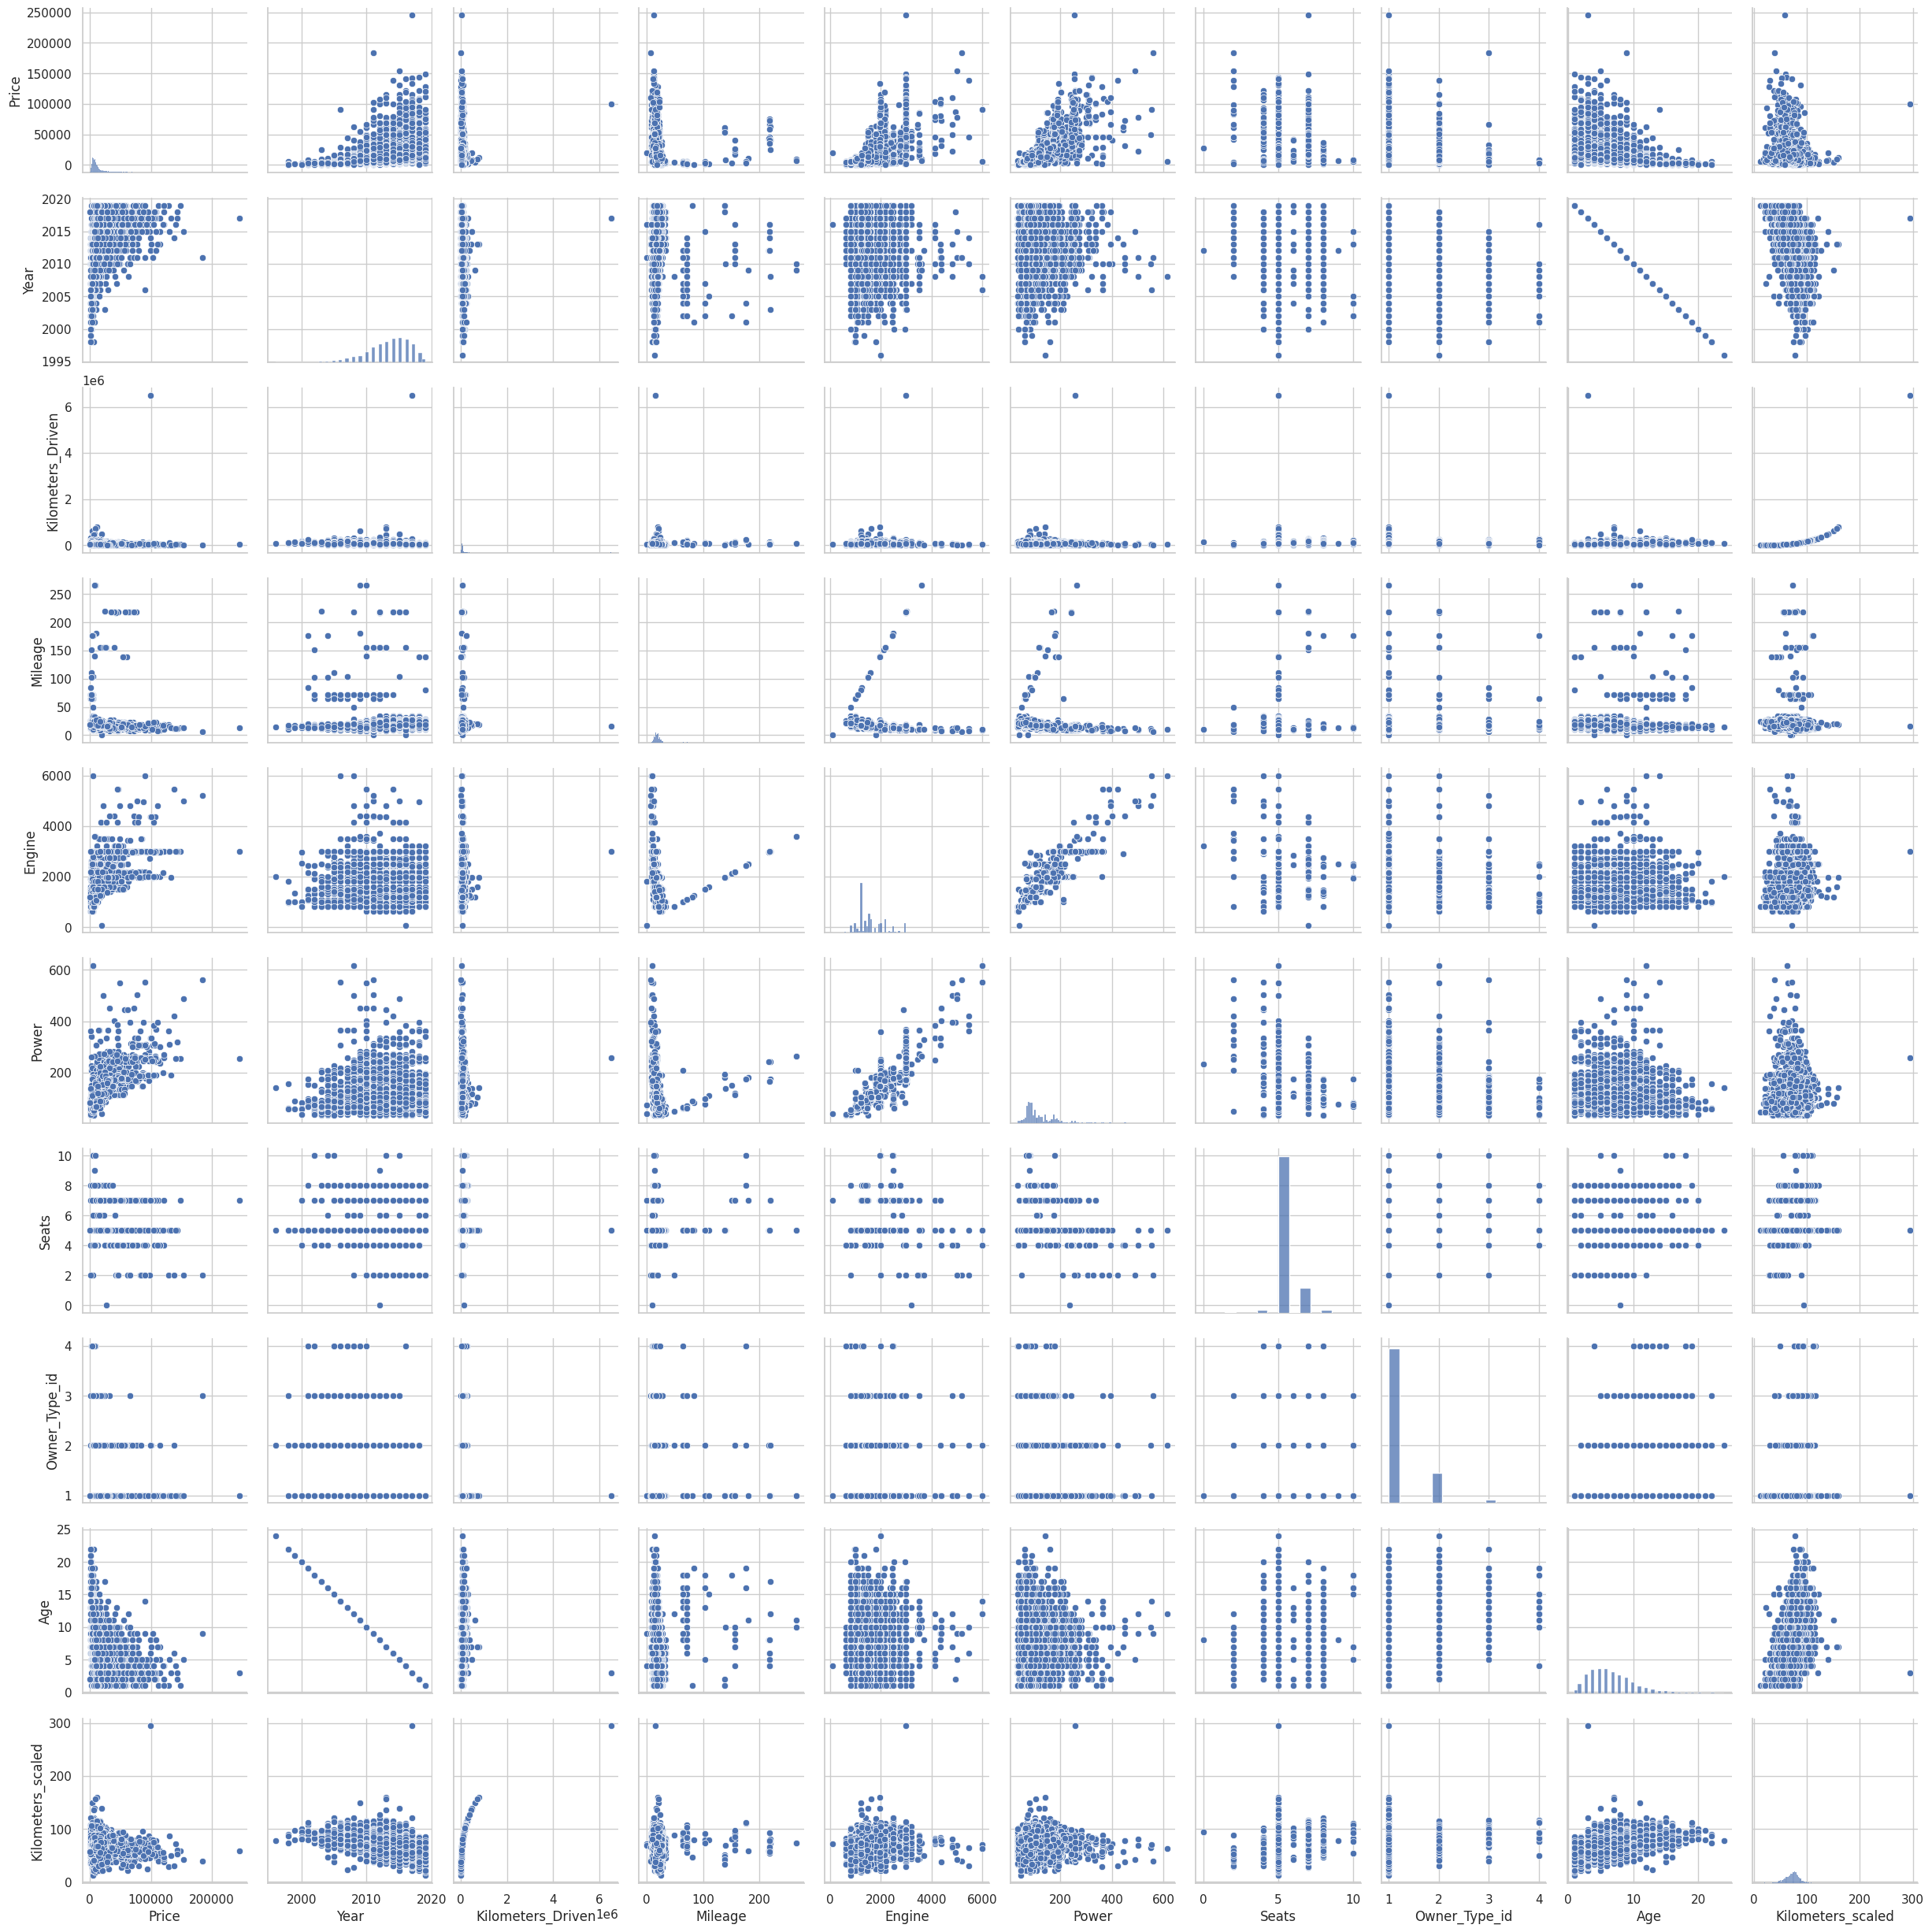

In [68]:
# 목적 - 설명 간 산점도
sns.set(style='whitegrid')
sns.pairplot(df[num_columns])
plt.show()

In [77]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Owner_Type_id,Brand_Country,Brand_level,Age,Kilometers_scaled
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,1.0,India,middle_low,10,79.921806
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,1.0,Korea,middle_low,5,67.643880
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,1.0,Japan,middle_low,9,69.996611
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,1.0,India,middle_low,8,84.506617
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,2.0,Europe,high,7,67.481505


<Axes: xlabel='Transmission', ylabel='Price'>

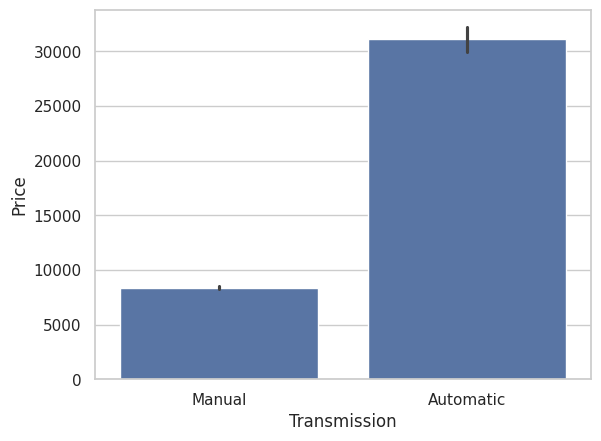

In [78]:
sns.barplot(x='Transmission',y='Price',data=df)

<Axes: xlabel='Engine', ylabel='Power'>

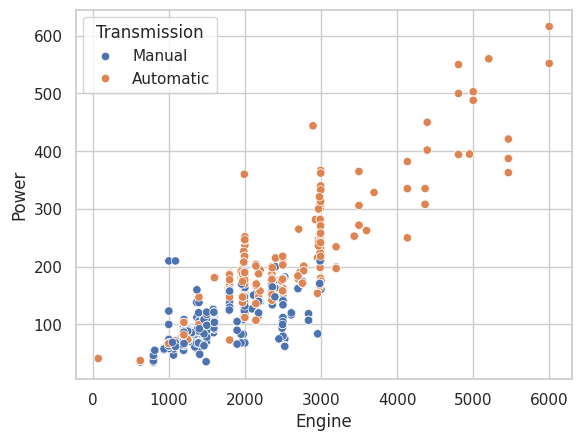

In [84]:
sns.scatterplot(data=df,x='Engine',y='Power',hue='Transmission')

<Axes: xlabel='Power', ylabel='Price'>

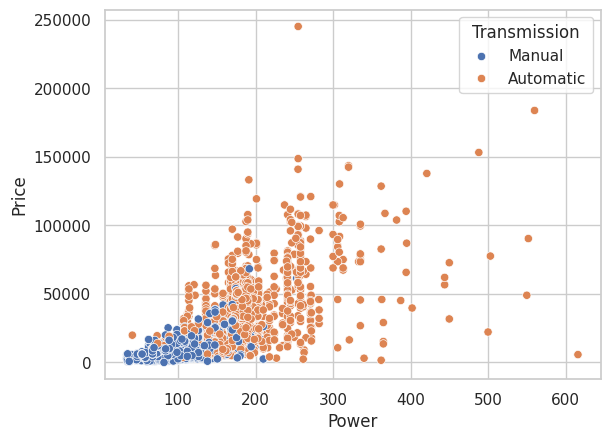

In [86]:
sns.scatterplot(data=df,x='Power',y='Price',hue='Transmission')

<Axes: xlabel='Age', ylabel='Price'>

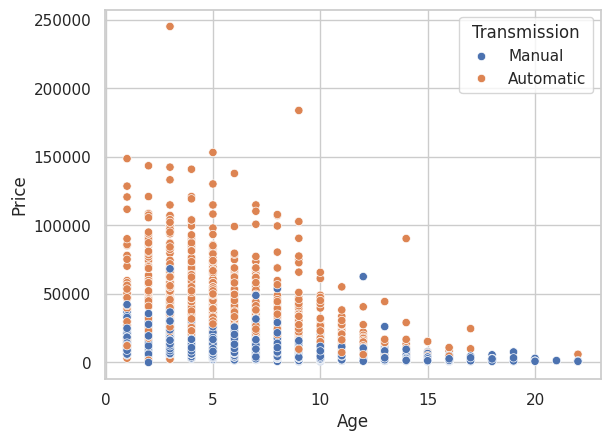

In [87]:
sns.scatterplot(data=df,x='Age',y='Price',hue='Transmission')

<Axes: xlabel='Seats', ylabel='Price'>

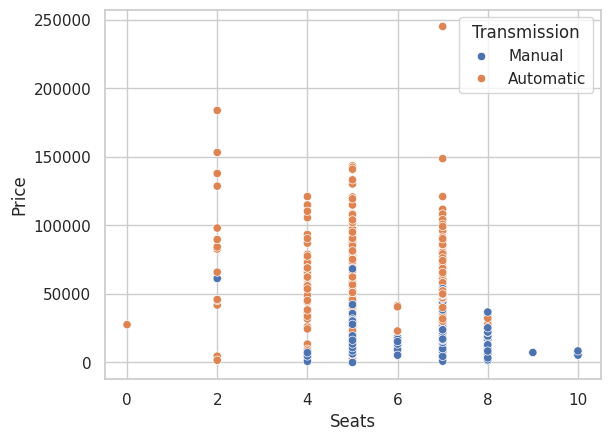

In [88]:
sns.scatterplot(data=df,x='Seats',y='Price',hue='Transmission')

<Axes: xlabel='Fuel_Type', ylabel='Price'>

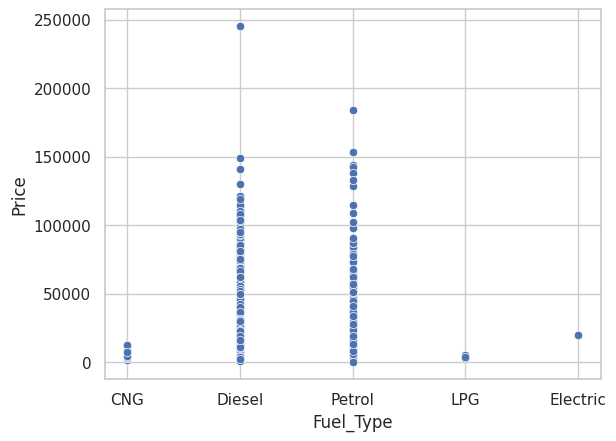

In [91]:
sns.scatterplot(data=df,x='Fuel_Type',y='Price')

<Axes: xlabel='Fuel_Type', ylabel='Price'>

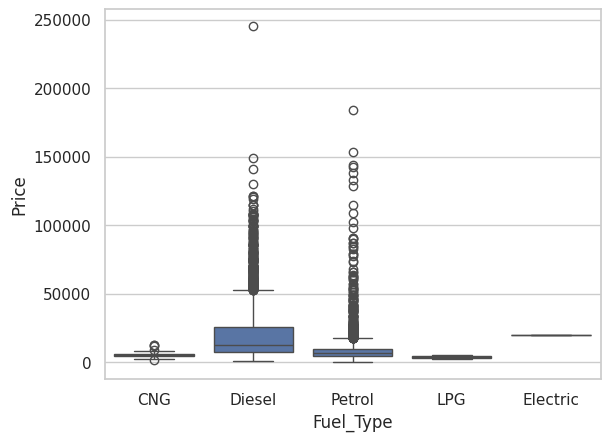

In [92]:
sns.boxplot(data=df,x='Fuel_Type',y='Price')

- 디젤과 휘발유에 이상치 존재  
이러한 이상치는 데이터의 오류일 수 있지만, 실제로 매우 비싼 차량의 가격일 가능성이 큼 -> 이상치를 제거하는 것은 데이터의 신뢰성에 영향을 미칠 수 있음
하지만 자동차 가격의 특성 상 높은 가격이 책정되는 것은 차종별로 당연함